# Clasificación de forma del rostro
Dataset: https://www.kaggle.com/datasets/niten19/face-shape-dataset

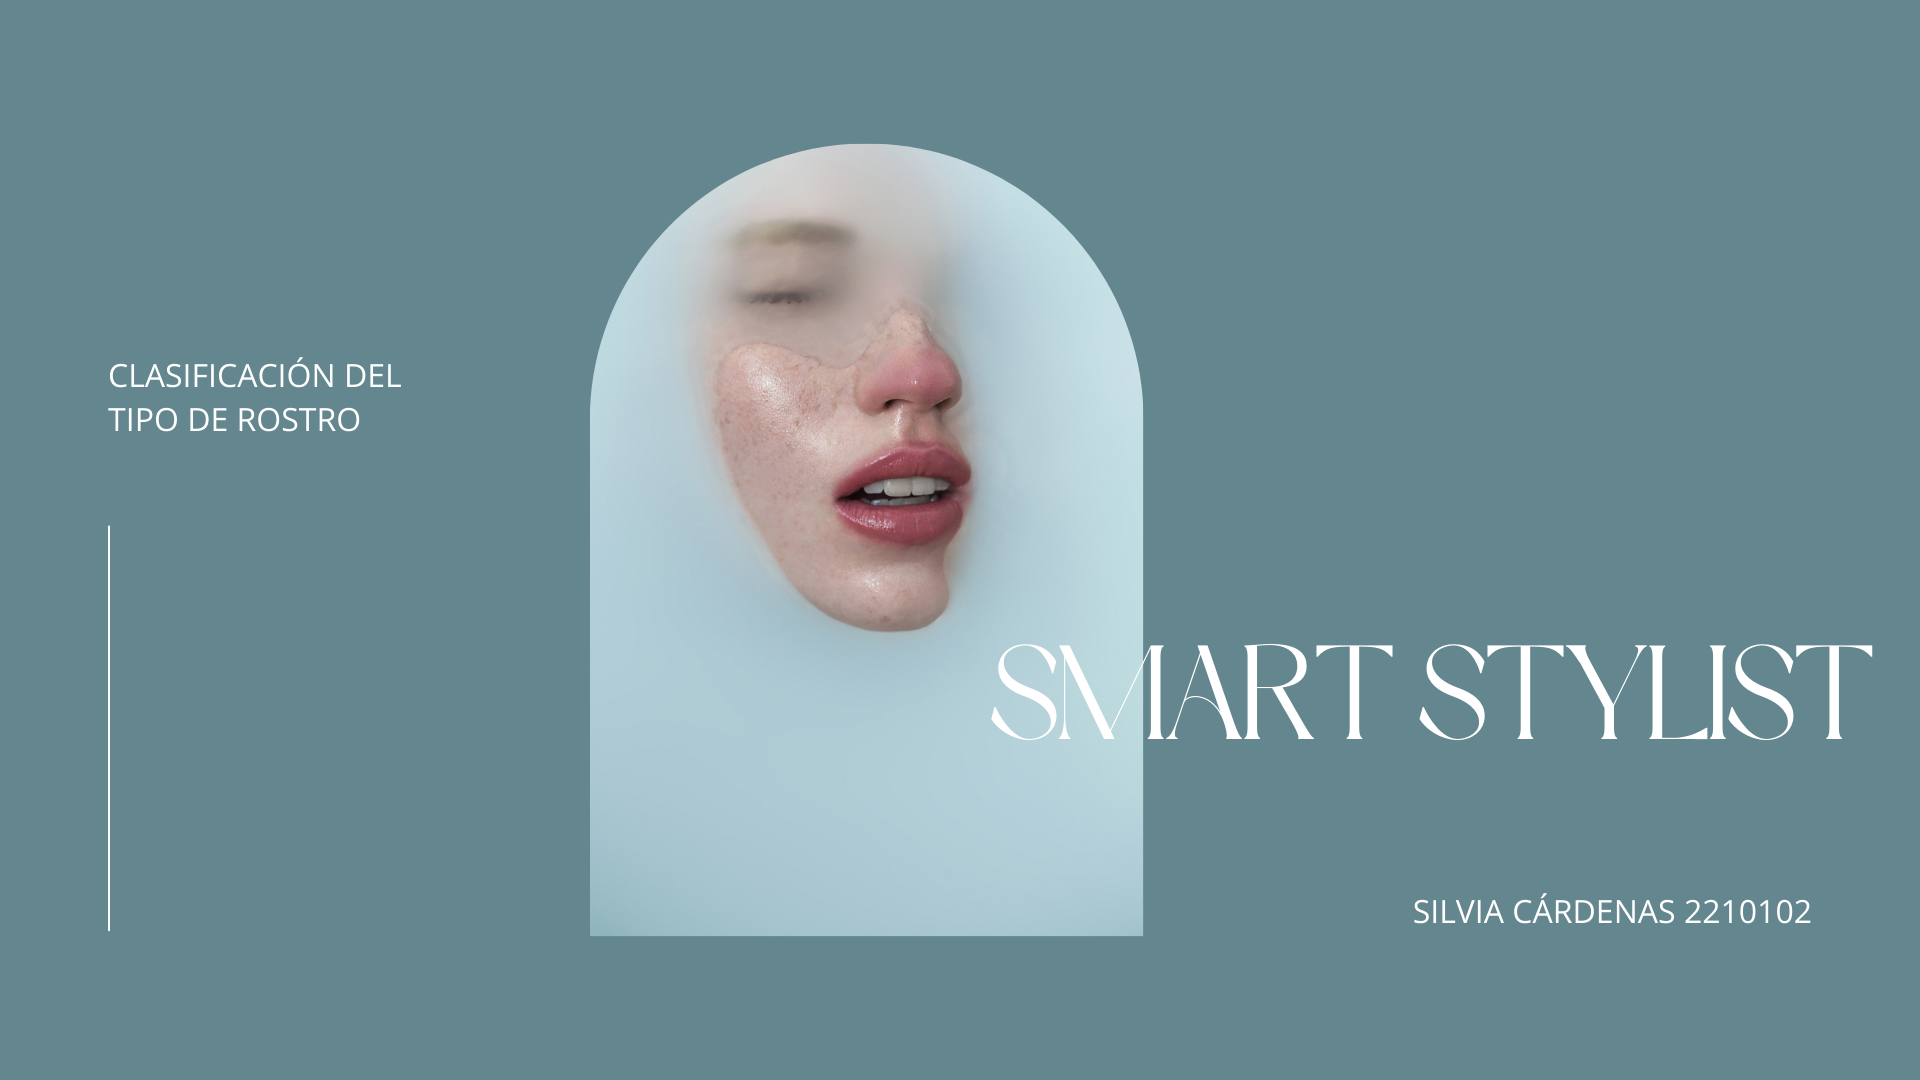

## Cargamos librerias

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dlib
import cv2
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

In [ ]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape
from tensorflow.keras.optimizers import Adam

## Importamos el dataset

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q':"title='archive.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('archive.zip')

In [ ]:
f.keys()

dict_keys(['id', 'kind', 'userPermission', 'fileExtension', 'md5Checksum', 'selfLink', 'ownerNames', 'lastModifyingUserName', 'editable', 'writersCanShare', 'downloadUrl', 'mimeType', 'parents', 'appDataContents', 'iconLink', 'shared', 'lastModifyingUser', 'owners', 'headRevisionId', 'copyable', 'etag', 'alternateLink', 'embedLink', 'webContentLink', 'fileSize', 'copyRequiresWriterPermission', 'spaces', 'title', 'labels', 'explicitlyTrashed', 'createdDate', 'modifiedDate', 'modifiedByMeDate', 'lastViewedByMeDate', 'markedViewedByMeDate', 'quotaBytesUsed', 'version', 'originalFilename', 'capabilities'])

In [ ]:
!unzip archive.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: FaceShape Dataset/testing_set/Heart/heart (123).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (13).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (135).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (136).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (137).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (138).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (139).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (140).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (141).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (156).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (161).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (163).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (189).jpg  
  inflating: FaceShape Dataset/testing_set/Heart/heart (192).jp

In [ ]:
PATH = '/content/FaceShape Dataset'

In [ ]:
os.listdir(PATH)

['training_set', 'desktop.ini', 'testing_set']

In [ ]:
train_dir = os.path.join(PATH, 'training_set')
test_dir = os.path.join(PATH, 'testing_set')

In [ ]:
train_heart_dir = os.path.join(train_dir, 'Heart')
train_oblong_dir = os.path.join(train_dir, 'Oblong')
train_oval_dir = os.path.join(train_dir, 'Oval')
train_round_dir = os.path.join(train_dir, 'Round')
train_square_dir = os.path.join(train_dir, 'Square')

test_heart_dir = os.path.join(test_dir, 'Heart')
test_oblong_dir = os.path.join(test_dir, 'Oblong')
test_oval_dir = os.path.join(test_dir, 'Oval')
test_round_dir = os.path.join(test_dir, 'Round')
test_square_dir = os.path.join(test_dir, 'Square')

In [ ]:
train_direct = [train_heart_dir,train_oblong_dir,train_oval_dir,train_round_dir,train_square_dir]
for i in range(len(train_direct)):
  print('Cantidad de imagenes del directorio ',train_direct[i],':',len(os.listdir(train_direct[i])))

Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Heart : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Oblong : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Oval : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Round : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Square : 800


In [ ]:
test_direct = [test_heart_dir,test_oblong_dir,test_oval_dir,test_round_dir,test_square_dir]
for i in range(len(test_direct)):
  print('Cantidad de imagenes del directorio ',test_direct[i],':',len(os.listdir(test_direct[i])))

Cantidad de imagenes del directorio  /content/FaceShape Dataset/testing_set/Heart : 200
Cantidad de imagenes del directorio  /content/FaceShape Dataset/testing_set/Oblong : 200
Cantidad de imagenes del directorio  /content/FaceShape Dataset/testing_set/Oval : 200
Cantidad de imagenes del directorio  /content/FaceShape Dataset/testing_set/Round : 201
Cantidad de imagenes del directorio  /content/FaceShape Dataset/testing_set/Square : 200


In [ ]:
# Eliminar imágenes específicas que son problematicas
specific_images_to_remove = [
    '/content/FaceShape Dataset/training_set/Heart/heart (633).jpg',
    '/content/FaceShape Dataset/training_set/Square/square (84).jpg'
]

for img_path in specific_images_to_remove:
    try:
        os.remove(img_path)
        print(f'Eliminado: {img_path}')
    except FileNotFoundError:
        print(f'No se encontró la imagen: {img_path}')

Eliminado: /content/FaceShape Dataset/training_set/Heart/heart (633).jpg
Eliminado: /content/FaceShape Dataset/training_set/Square/square (84).jpg


In [ ]:
#Revisamos que se hayan borrado correctamente las imágenes problematicas
train_direct = [train_heart_dir,train_oblong_dir,train_oval_dir,train_round_dir,train_square_dir]
for i in range(len(train_direct)):
  print('Cantidad de imagenes del directorio ',train_direct[i],':',len(os.listdir(train_direct[i])))

Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Heart : 799
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Oblong : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Oval : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Round : 800
Cantidad de imagenes del directorio  /content/FaceShape Dataset/training_set/Square : 799


In [ ]:
#Vamos a utilizar un generador de imagenes para el trabajo
image_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
    target_size=(256, 256),
    directory=train_dir,
    shuffle=True,
    class_mode='categorical')

Found 3998 images belonging to 5 classes.


In [ ]:
test_data_gen = image_gen.flow_from_directory(
    target_size=(256, 256),
    directory=test_dir,
    shuffle=False,
    class_mode='categorical')

Found 1000 images belonging to 5 classes.


In [ ]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

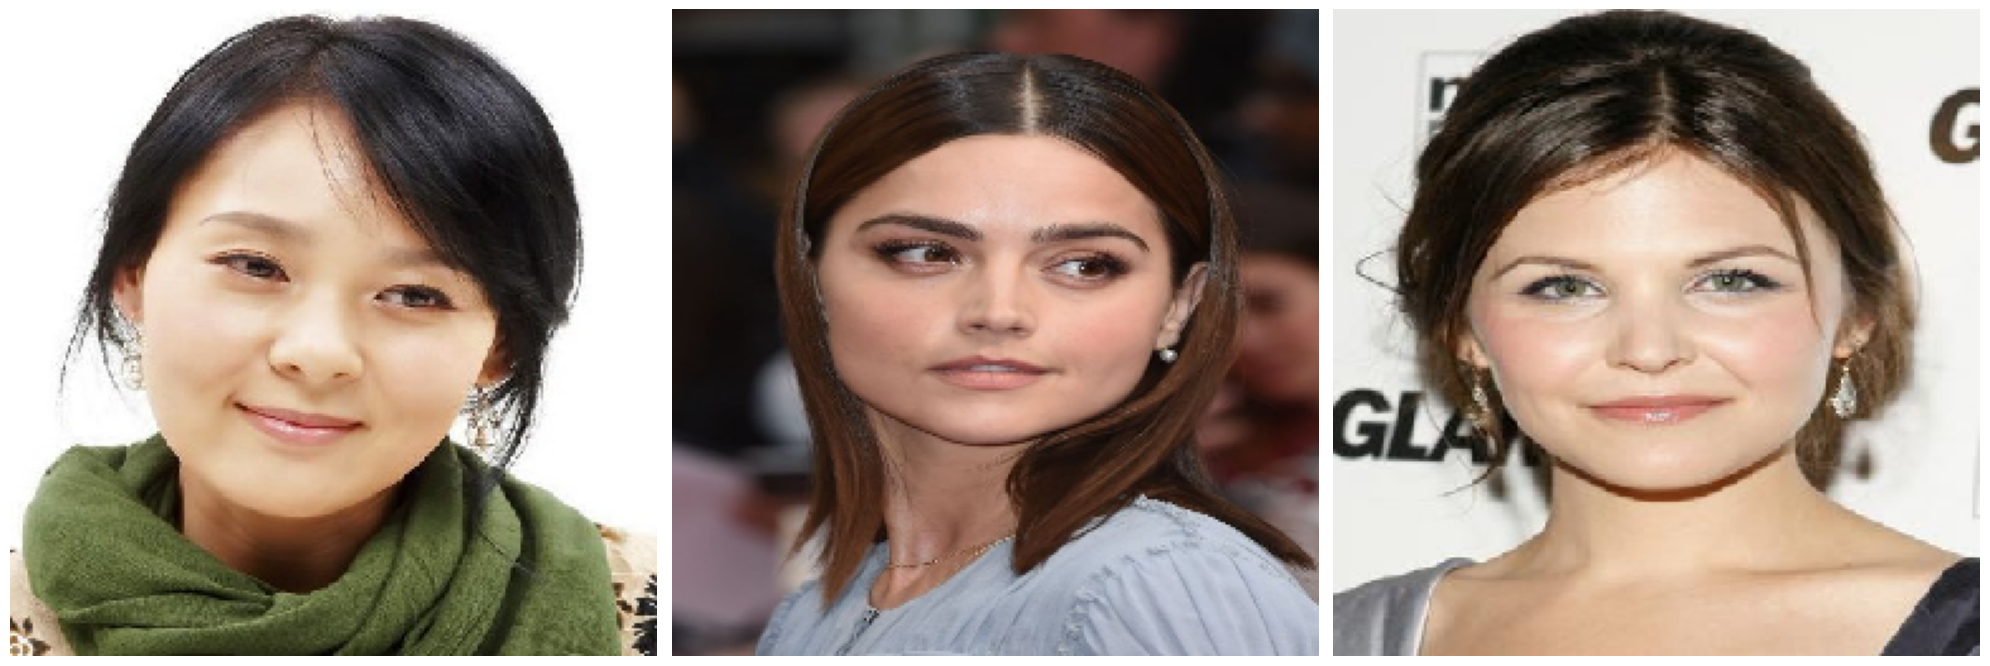

In [ ]:
plotImages(sample_training_images[:3])

# Utilizando las imágenes del dataset normal


# VGG16
Se uso este modelo preentrenado con los pesos de ImageNet para clasificar los rostros con las imágenes sin ningún procesamiento previo, para ver el rendimiento de este y poder compararlo con un dataset un poco más pulido posteriormente.

In [ ]:
# Creamos el generador de datos con división de validación para entrenar el modelo
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Usar el 20% de los datos para validación
)

train_data_gen = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='training'  # Los datos de entrenamiento
)

val_data_gen = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='validation'  # Los datos de validación
)

Found 3200 images belonging to 5 classes.
Found 798 images belonging to 5 classes.


In [ ]:
model_VGG16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))
model_VGG16.trainable = False

# Congelar las capas del modelo VGG16
for layer in model_VGG16.layers:
    layer.trainable = False

In [ ]:
model_VGG =  tf.keras.Sequential([
    model_VGG16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_VGG.summary()
print("number of layers to train: ", len(model_VGG.trainable_variables))

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 64)                524352    
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_17 (Dense)            (None, 5)                 325       
                                                                 
Total params: 15239365 (58.13 MB)
Trainable params: 524677 (2.00 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________
number of

In [ ]:
# Compilar el modelo
model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Se utiliza el learning rate scheduler para irlo variando
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

In [ ]:
#Primeras 10 epocas, tiempo aprox 140 mins -> 2h y 20mins
history = model_VGG.fit(train_data_gen, batch_size=256, epochs=10, validation_data=val_data_gen,callbacks=[lr_scheduler])

Epoch 1/10
50/50 [==============================] - 893s 18s/step - loss: 1.5909 - accuracy: 0.2837 - val_loss: 1.4865 - val_accuracy: 0.3521 - lr: 1.0000e-04
Epoch 2/10
50/50 [==============================] - 843s 17s/step - loss: 1.4520 - accuracy: 0.3775 - val_loss: 1.4342 - val_accuracy: 0.3822 - lr: 1.0000e-04
Epoch 3/10
50/50 [==============================] - 872s 18s/step - loss: 1.3692 - accuracy: 0.4297 - val_loss: 1.4024 - val_accuracy: 0.4148 - lr: 1.0000e-04
Epoch 4/10
50/50 [==============================] - 836s 17s/step - loss: 1.2875 - accuracy: 0.4812 - val_loss: 1.3656 - val_accuracy: 0.4486 - lr: 1.0000e-04
Epoch 5/10
50/50 [==============================] - 837s 17s/step - loss: 1.2235 - accuracy: 0.5166 - val_loss: 1.3523 - val_accuracy: 0.4474 - lr: 1.0000e-04
Epoch 6/10
50/50 [==============================] - 835s 17s/step - loss: 1.1742 - accuracy: 0.5419 - val_loss: 1.3446 - val_accuracy: 0.4574 - lr: 1.0000e-04
Epoch 7/10
50/50 [============================

In [ ]:
#Se descargo el modelo para guardar sus pesos tras el largo tiempo de .fit()
model_VGG.save('face_shape_classifier.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Cargar el modelo guardado para entrenarlo otros 10 epochs
model_VGG = load_model('face_shape_classifier.h5')

# Continuar el entrenamiento otros 10 epochs, 140 mins -> 2h y 20mins
history = model_VGG.fit(train_data_gen, batch_size=256, epochs=10, validation_data=val_data_gen, callbacks=[lr_scheduler])

Epoch 1/10
50/50 [==============================] - 847s 17s/step - loss: 0.9272 - accuracy: 0.6875 - val_loss: 1.2957 - val_accuracy: 0.4737 - lr: 1.0000e-05
Epoch 2/10
50/50 [==============================] - 840s 17s/step - loss: 0.9137 - accuracy: 0.6938 - val_loss: 1.2975 - val_accuracy: 0.4799 - lr: 1.0000e-05
Epoch 3/10
50/50 [==============================] - 843s 17s/step - loss: 0.9007 - accuracy: 0.7094 - val_loss: 1.2956 - val_accuracy: 0.4799 - lr: 1.0000e-05
Epoch 4/10
50/50 [==============================] - 842s 17s/step - loss: 0.8983 - accuracy: 0.7016 - val_loss: 1.2959 - val_accuracy: 0.4674 - lr: 1.0000e-05
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 0.9009 - accuracy: 0.7006 
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
50/50 [==============================] - 842s 17s/step - loss: 0.9009 - accuracy: 0.7006 - val_loss: 1.2956 - val_accuracy: 0.4699 - lr: 1.0000e-05
Epoch 6/10
50/50 [===========================

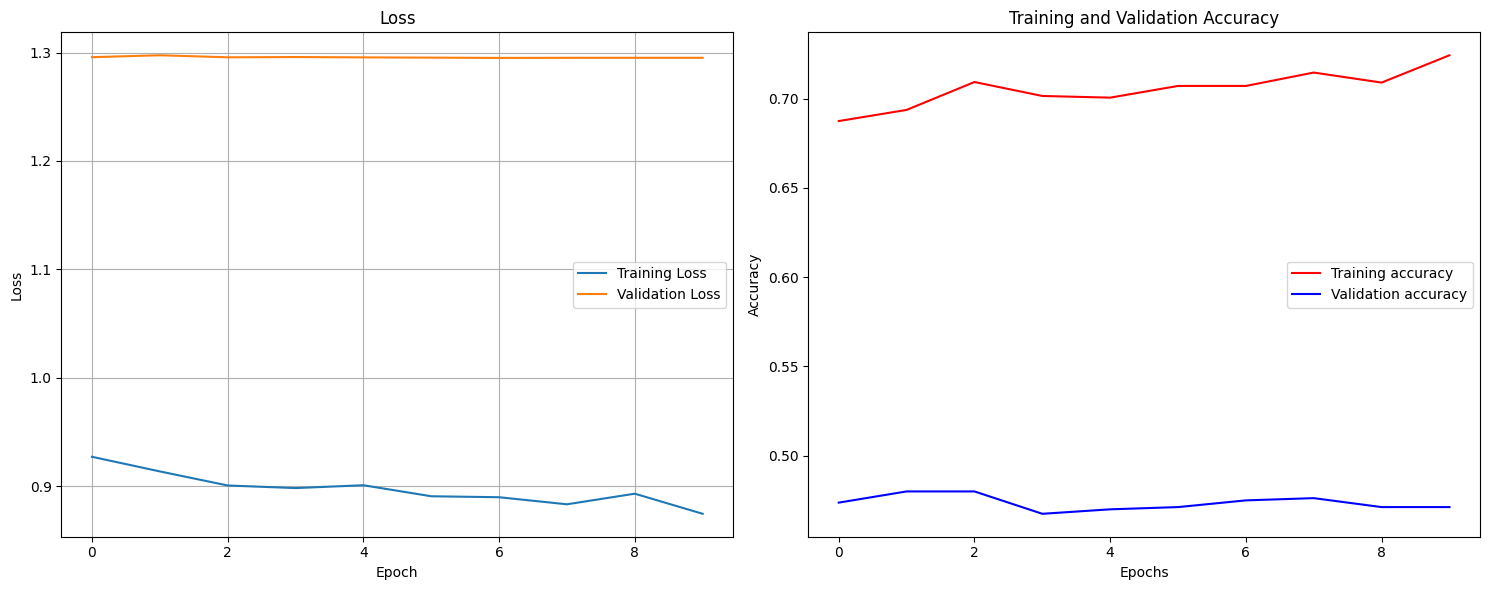

In [ ]:
# Se busca plottear la pérdida y la precisión del modelo
# Gráfica de loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfica del accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Se aprecia tendencia a un overfitting, no se realizaron más epochs por esto mismo, el dataset tiene algunas imagenes no muy claras y que no se enfocan en el rostro de la persona.

In [ ]:
# Ajustamos a las medidas en las que se entrenaron el modelo
test_data_gen = image_gen.flow_from_directory(
    target_size=(128,128),
    directory=test_dir,
    shuffle=False,
    class_mode='categorical')

Found 1000 images belonging to 5 classes.


In [ ]:
#Hacemos las predicciones
predictions = model_VGG.predict(test_data_gen)
predicted_classes = predictions.argmax(axis=-1)
true_classes = test_data_gen.classes

32/32 [==============================] - 210s 7s/step


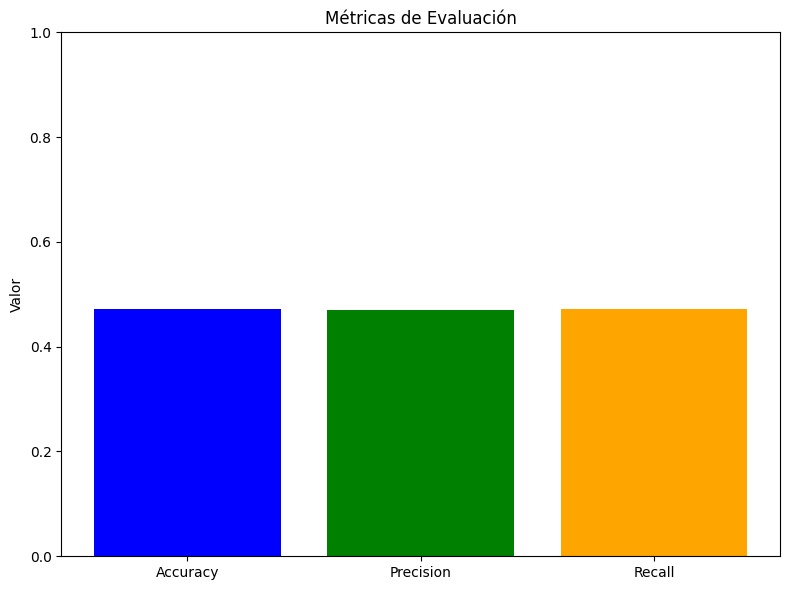

Accuracy: 0.4720
Precision: 0.4695
Recall: 0.4720


In [ ]:
# Calculamos métricas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')

# Métricas
plt.figure(figsize=(8, 6))
metrics_labels = ['Accuracy', 'Precision', 'Recall']
metrics_values = [accuracy, precision, recall]
plt.bar(metrics_labels, metrics_values, color=['blue', 'green', 'orange'])
plt.title('Métricas de Evaluación')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.tight_layout()

plt.show()

# Imprimir los valores de las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

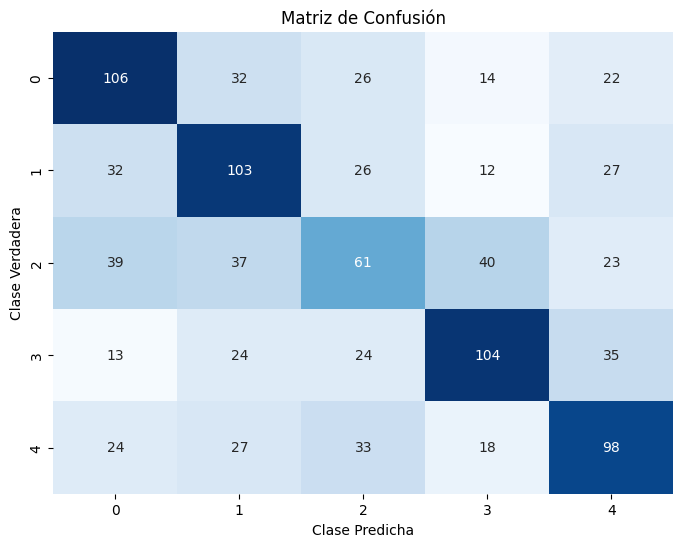

In [ ]:
# Calcular la matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
# Se dibuja con Seaborn la matriz
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()
#Clases:
#0 -> Heart, 1 -> Oblong, 2 -> Oval, 3 -> Round, 4 -> Square

#ResNet50
Dado que es uno de los mejores modelos pre-entrenados para la detección de rostros, en este caso no dio buenos resultados al intentar hacerle fine-tuning. Nunca hubo un cambio significativo en ese mínimo local que encontró.

In [ ]:
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_ResNet50.trainable = False

# Congelar las capas del modelo VGG16
for layer in model_ResNet50.layers:
    layer.trainable = False

model_Res =  tf.keras.Sequential([
    model_ResNet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_Res.summary()
print("number of layers to train: ", len(model_Res.trainable_variables))

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_7 (Flatten)         (None, 32768)             0         
                                                                 
 dense_42 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_20 (Dropout)        (None, 128)               0         
                                                                 
 dense_43 (Dense)            (None, 64)                8256      
                                                                 
 dropout_21 (Dropout)        (None, 64)                0         
                                                                 
 dense_44 (Dense)            (None, 64)               

In [ ]:
# Compilar el modelo
model_Res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Se utiliza el learning rate scheduler para irlo variando
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

In [ ]:
#Primeras 10 epocas, NO da buenos resultados
history = model_Res.fit(train_data_gen, batch_size=256, epochs=10, validation_data=val_data_gen,callbacks=[lr_scheduler])

Epoch 1/10
50/50 [==============================] - 305s 5s/step - loss: 1.7390 - accuracy: 0.2034 - val_loss: 1.6104 - val_accuracy: 0.2030 - lr: 0.0010
Epoch 2/10
50/50 [==============================] - 252s 5s/step - loss: 1.6202 - accuracy: 0.2009 - val_loss: 1.6092 - val_accuracy: 0.2030 - lr: 0.0010
Epoch 3/10
50/50 [==============================] - 252s 5s/step - loss: 1.6113 - accuracy: 0.1972 - val_loss: 1.6093 - val_accuracy: 0.2005 - lr: 0.0010
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 1.6098 - accuracy: 0.1991
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
50/50 [==============================] - 251s 5s/step - loss: 1.6098 - accuracy: 0.1991 - val_loss: 1.6093 - val_accuracy: 0.2093 - lr: 0.0010
Epoch 5/10
50/50 [==============================] - 283s 6s/step - loss: 1.6095 - accuracy: 0.1988 - val_loss: 1.6091 - val_accuracy: 0.2068 - lr: 1.0000e-04
Epoch 6/10
50/50 [==============================] - ETA: 0s - loss

#Dataset de imágenes recortadas
Se buscó limpiar un poco las imágenes para enfocar los píxeles en los rostros del dataset, eliminando el fondo y otras variables que no aportan a la clasificación. Por lo tanto, se recortó el dataset a solo los rostros.

In [ ]:
# Directorios de entrenamiento y prueba originales
train_dir = os.path.join(PATH, 'training_set')
test_dir = os.path.join(PATH, 'testing_set')

# Directorios de salida para los rostros recortados
train_dir_recorte = os.path.join(PATH, 'recorte/training_set')
test_dir_recorte = os.path.join(PATH, 'recorte/testing_set')

# Crea los directorios de salida si no existen
if not os.path.exists(train_dir_recorte):
    os.makedirs(train_dir_recorte)
if not os.path.exists(test_dir_recorte):
    os.makedirs(test_dir_recorte)

# Detector de rostros de dlib
detector = dlib.get_frontal_face_detector()

def detectar_y_guardar_rostros(image_path, output_dir, detector):
    # Verificar si image_path es una ruta válida a un archivo
    if not os.path.isfile(image_path):
        print(f"La ruta {image_path} no es un archivo válido.")
        return

    try:

        imagen = cv2.imread(image_path)
        if imagen is None:
            print(f"No se pudo leer la imagen {image_path}.")
            return

        # Convertir a escala de grises porque dlib necesita una imagen en grises
        gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        # Detectar rostros en la imagen en escala de grises
        rostros = detector(gris)

        # Verificar si se detectaron rostros
        if len(rostros) == 0:
            print(f"No se encontraron rostros en la imagen {image_path}.")
            return


        for i, rostro in enumerate(rostros):
            x, y, w, h = (rostro.left(), rostro.top(), rostro.width(), rostro.height())
            rostro_recortado = imagen[y:y+h, x:x+w]
            # Obtener la clase (etiqueta) de la imagen original
            class_name = os.path.basename(os.path.dirname(image_path))
            output_class_dir = os.path.join(output_dir, class_name)

            # Crear el directorio si no existe
            if not os.path.exists(output_class_dir):
                os.makedirs(output_class_dir)

            rostro_filename = os.path.join(output_class_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}_{i}.jpg")
            # Guardar el rostro recortado
            cv2.imwrite(rostro_filename, rostro_recortado)

    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {str(e)}")

# Procesar cada imagen en el dataset original de entrenamiento y prueba
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            detectar_y_guardar_rostros(image_path, train_dir_recorte, detector)

for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            detectar_y_guardar_rostros(image_path, test_dir_recorte, detector)

No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (662).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (404).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (633).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (678).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (642).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (680).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Round/round (654).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Oval/oval (849).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Oval/oval (748).jpg.
No se encontraron rostros en la imagen /content/FaceShape Dataset/training_set/Oval/ov

In [ ]:
#Análisis de las imágenes en las cuales no se encontraron rostros:
#No encontré correlación entre estas imágenes ni nada raro en la mayoría, por ejemplo:

#Training
#Oval total -> 4 img
#Oval 748: Rostro de frente, imagen recortada bordeada figura.
#Oval 750: Rostro de frente, color normal.
#Oval 849: Rostro de frente, color normal.
#Oval 708: Rostro de frente, color normal, muchos bordes (?).

#Oblong total -> 7 img
#Oblong 619: Rostro de frente, color normal.
#Oblong 170: Rostro de lado, blanco y negro.
#Oblong 273: Rostro ligeramente de lado, color normal.
#Oblong 724: Imagen corrupta.

#Round total -> 7 img
#Round 662: Rostro ligeramente inclinado, color normal.
#Round 404: Rostro de frente, color normal, llevaba gafas de sol negras.
#Round 680: Rostro de frente, color normal.
#Round 678: Rostro ligeramente inclinado, color normal.

#Heart total -> 3 img
#Heart 690: Rostro de frente, color normal, recortada frente.
#Heart 904: Rostro de frente, color normal, recortada pelo.
#Heart 121: Rostro de frente, color normal, marca de agua centro.

#Square total -> 0 img

#Test
#Oval total -> 2 img
#Oval 687: Rostro de frente, imagen descentralizada izquierda.
#Oval 698: Rostro de frente, color normal.

#Oblong total -> 2 img
#Oblong 559: Rostro de frente, color normal.
#Oblong 547: Rostro de frente, color normal.

#Round total -> 3 img
#Round 269: Rostro de frente, color normal.
#Round 520: Rostro ligeramente inclinado, color normal.
#Round 598: Rostro ligeramente inclinado, color normal.

#Heart total -> 0 img

#Square total -> 0 img

In [ ]:
train_data_gen_recorte = image_gen.flow_from_directory(
    target_size=(256, 256),
    directory=train_dir_recorte,
    shuffle=True,
    class_mode='categorical')

Found 3985 images belonging to 5 classes.


In [ ]:
test_data_gen_recorte = image_gen.flow_from_directory(
    target_size=(256, 256),
    directory=test_dir_recorte,
    shuffle=False,
    class_mode='categorical')

Found 995 images belonging to 5 classes.


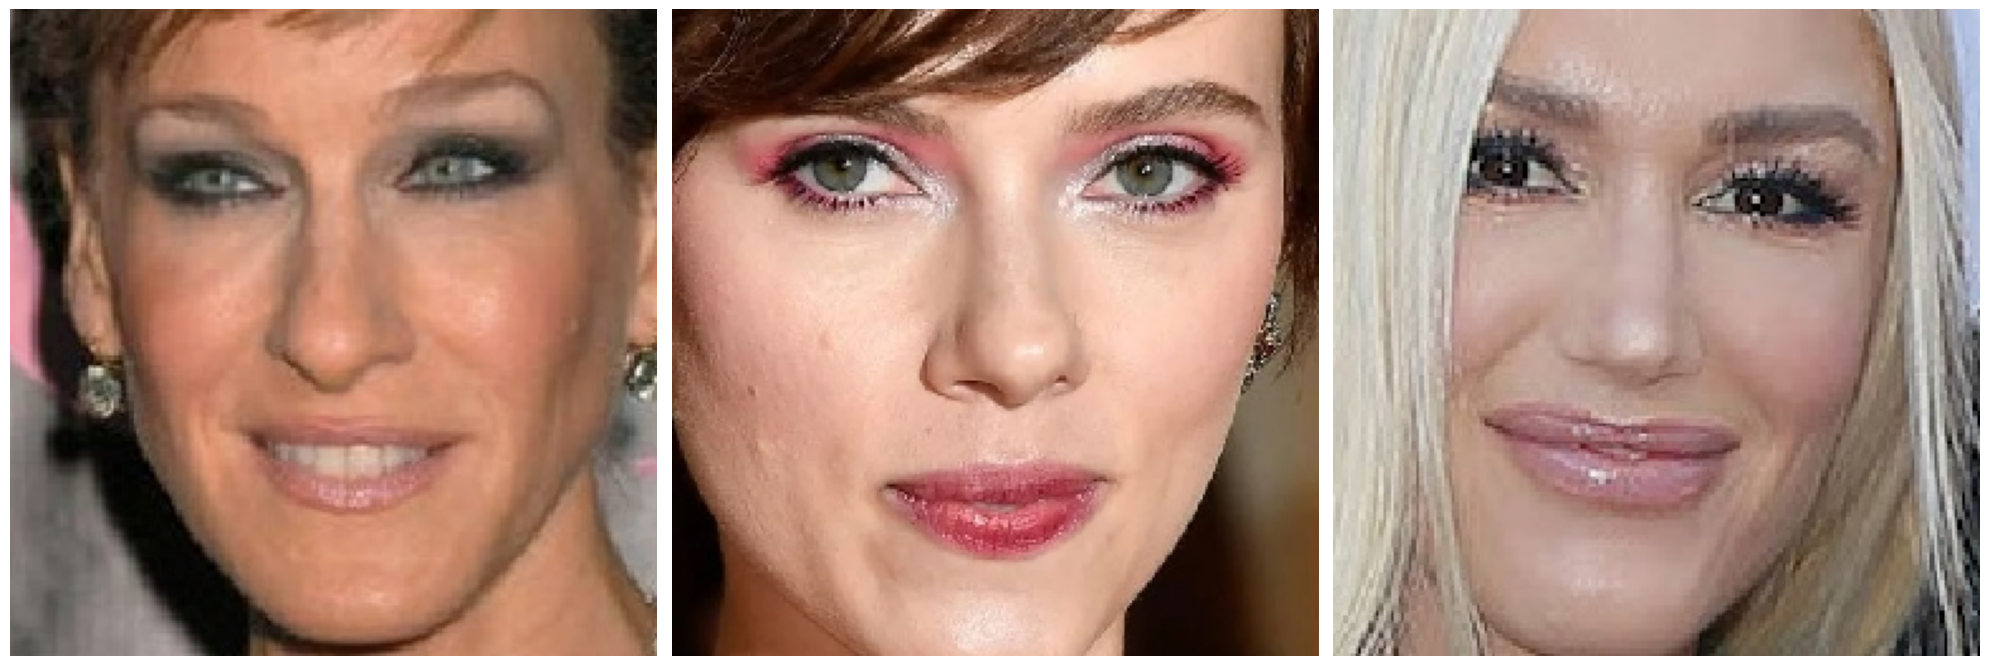

In [ ]:
sample_training_images_recorte, _ = next(train_data_gen_recorte)
plotImages(sample_training_images_recorte[:3])

#VGG16
En esta ocasión, queriendo comparar correctamente ambos datasets, se utilizó exactamente el mismo modelo con las mismas proporciones para ver si al centrarse más en el rostro se obtenían mejores resultados.

In [ ]:
# Nuevamente se crea un generador de datos con división de validación para entrenar el modelo
train_data_gen_recorte = datagen.flow_from_directory(
    directory=train_dir_recorte,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_data_gen_recorte = datagen.flow_from_directory(
    directory=train_dir_recorte,
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 3191 images belonging to 5 classes.
Found 794 images belonging to 5 classes.


In [ ]:
# Declaramos el mismo modelo nuevamente para no tomar el que tiene pesos pre-entrenados y poder comparar la precisión
model_VGG16 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(128,128, 3))
model_VGG16.trainable = False

# Congelar las capas del modelo VGG16
for layer in model_VGG16.layers:
    layer.trainable = False

model_VGG =  tf.keras.Sequential([
    model_VGG16,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_VGG.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Se utiliza el learning rate scheduler para irlo variando
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
#Primeras 10 epochs, 140mins -> 2h y 20mins
history = model_VGG.fit(train_data_gen_recorte, batch_size=256, epochs=10, validation_data=val_data_gen_recorte)

Epoch 1/10
100/100 [==============================] - 821s 8s/step - loss: 1.5415 - accuracy: 0.3262 - val_loss: 1.3856 - val_accuracy: 0.4093
Epoch 2/10
100/100 [==============================] - 817s 8s/step - loss: 1.3208 - accuracy: 0.4616 - val_loss: 1.2499 - val_accuracy: 0.5050
Epoch 3/10
100/100 [==============================] - 823s 8s/step - loss: 1.1878 - accuracy: 0.5346 - val_loss: 1.1670 - val_accuracy: 0.5390
Epoch 4/10
100/100 [==============================] - 858s 9s/step - loss: 1.0977 - accuracy: 0.5669 - val_loss: 1.1062 - val_accuracy: 0.5655
Epoch 5/10
100/100 [==============================] - 816s 8s/step - loss: 1.0382 - accuracy: 0.5998 - val_loss: 1.1119 - val_accuracy: 0.5655
Epoch 6/10
100/100 [==============================] - 860s 9s/step - loss: 0.9806 - accuracy: 0.6371 - val_loss: 1.0601 - val_accuracy: 0.5806
Epoch 7/10
100/100 [==============================] - 818s 8s/step - loss: 0.9373 - accuracy: 0.6547 - val_loss: 0.9997 - val_accuracy: 0.6184

In [ ]:
# Nuevamente se guarda por las mismas razones
model_VGG.save('face_shape_classifier_recorte.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Cargar el modelo guardado
model_VGG = load_model('face_shape_classifier_recorte.h5')

# Continuar el entrenamiento otros 10 epochs, 140mins -> 2h y 20mins
history = model_VGG.fit(train_data_gen_recorte, batch_size=256, epochs=10, validation_data=val_data_gen_recorte, callbacks=[lr_scheduler])

Epoch 1/10
100/100 [==============================] - 832s 8s/step - loss: 0.7518 - accuracy: 0.7355 - val_loss: 0.9693 - val_accuracy: 0.6247 - lr: 1.0000e-04
Epoch 2/10
100/100 [==============================] - 863s 9s/step - loss: 0.7265 - accuracy: 0.7549 - val_loss: 0.9594 - val_accuracy: 0.6196 - lr: 1.0000e-04
Epoch 3/10
100/100 [==============================] - 830s 8s/step - loss: 0.6926 - accuracy: 0.7687 - val_loss: 0.9185 - val_accuracy: 0.6373 - lr: 1.0000e-04
Epoch 4/10
100/100 [==============================] - 824s 8s/step - loss: 0.6746 - accuracy: 0.7766 - val_loss: 0.9095 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 5/10
100/100 [==============================] - 832s 8s/step - loss: 0.6467 - accuracy: 0.7869 - val_loss: 0.9114 - val_accuracy: 0.6562 - lr: 1.0000e-04
Epoch 6/10
100/100 [==============================] - 825s 8s/step - loss: 0.6204 - accuracy: 0.8032 - val_loss: 0.9092 - val_accuracy: 0.6310 - lr: 1.0000e-04
Epoch 7/10
100/100 [====================

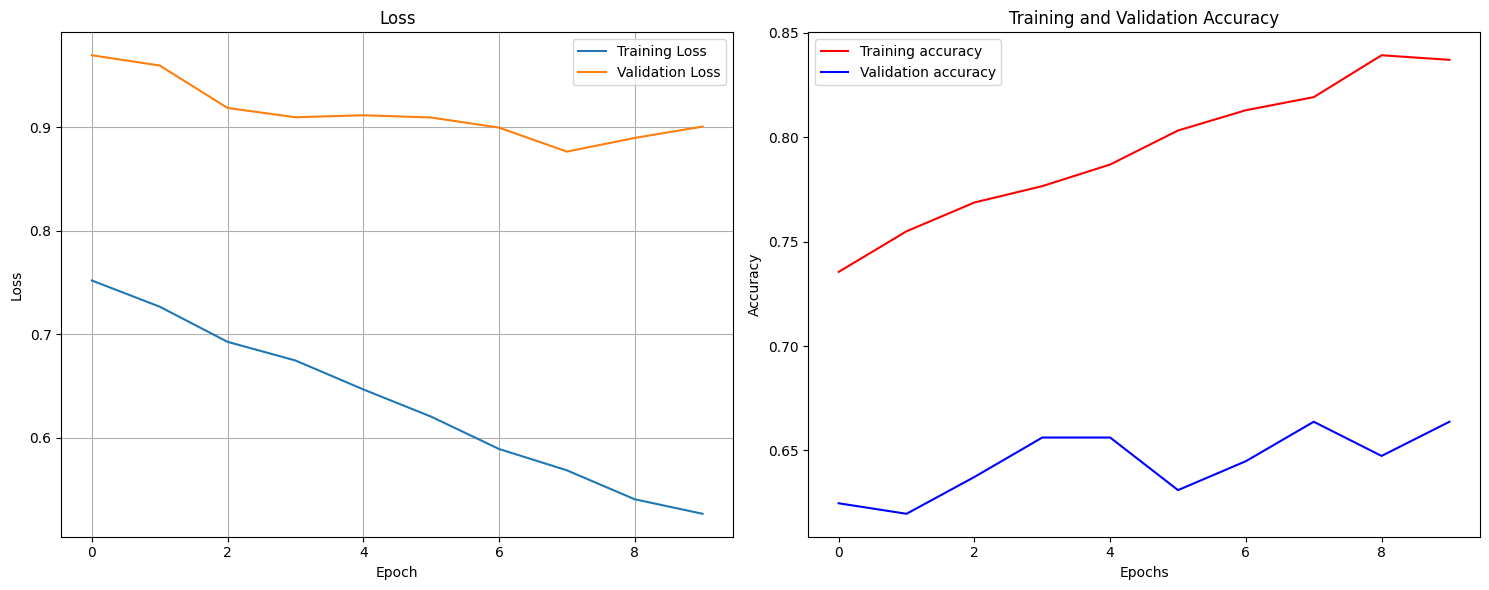

In [ ]:
# Gráfica de loss
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Gráfica del accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'r', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_data_gen_recorte = image_gen.flow_from_directory(
    target_size=(128,128),
    directory=test_dir_recorte,
    shuffle=False,
    class_mode='categorical')

Found 995 images belonging to 5 classes.


In [ ]:
#Hacemos las predicciones
predictions = model_VGG.predict(test_data_gen_recorte)
predicted_classes = predictions.argmax(axis=-1)
true_classes = test_data_gen_recorte.classes

32/32 [==============================] - 210s 6s/step


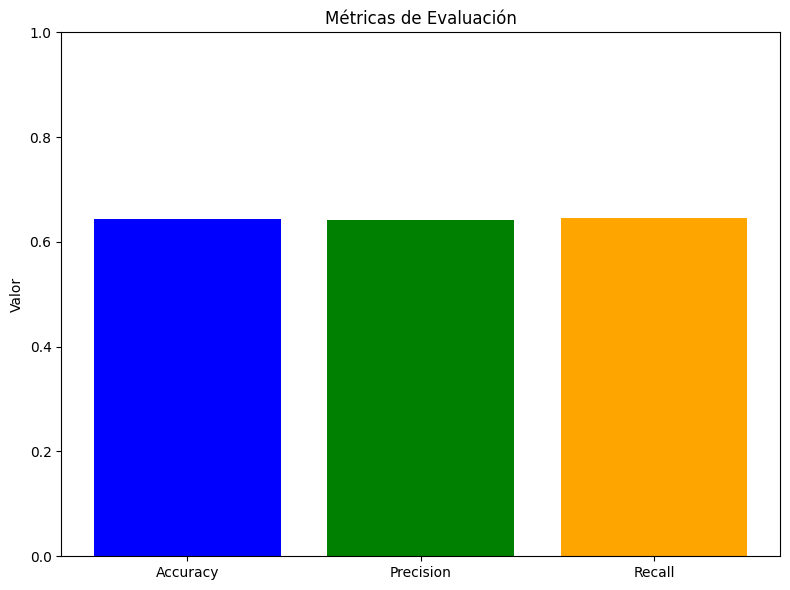

Accuracy: 0.6442
Precision: 0.6418
Recall: 0.6447


In [ ]:
# Se calculan métricas
accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='macro')
recall = recall_score(true_classes, predicted_classes, average='macro')

# Métricas
plt.figure(figsize=(8, 6))
metrics_labels = ['Accuracy', 'Precision', 'Recall']
metrics_values = [accuracy, precision, recall]
plt.bar(metrics_labels, metrics_values, color=['blue', 'green', 'orange'])
plt.title('Métricas de Evaluación')
plt.ylim(0, 1)
plt.ylabel('Valor')
plt.tight_layout()

plt.show()

# Imprimir los valores de las métricas
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

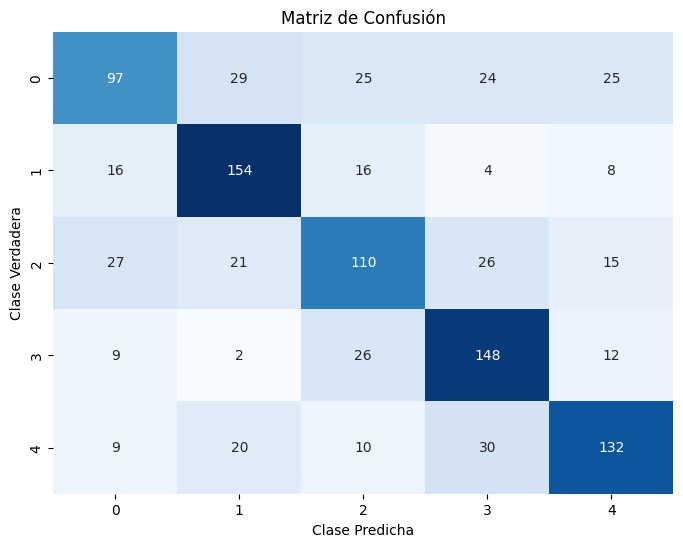

In [ ]:
# Matriz de confusión
cm = confusion_matrix(true_classes, predicted_classes)
# Configurar el gráfico
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', cbar=False)

plt.title('Matriz de Confusión')
plt.xlabel('Clase Predicha')
plt.ylabel('Clase Verdadera')
plt.show()

#ResNet50
Al igual que con el otro dataset se trató de usar, pero encontró la misma problemática de un mínimo local.

In [ ]:
model_ResNet50 = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
model_ResNet50.trainable = False

# Congelar las capas del modelo VGG16
for layer in model_ResNet50.layers:
    layer.trainable = False

model_Res =  tf.keras.Sequential([
    model_ResNet50,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(5, activation='softmax')
])

model_Res.summary()
print("number of layers to train: ", len(model_Res.trainable_variables))

# Compilar el modelo
model_Res.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Se utiliza el learning rate scheduler para irlo variando
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_8 (Flatten)         (None, 32768)             0         
                                                                 
 dense_47 (Dense)            (None, 128)               4194432   
                                                                 
 dropout_24 (Dropout)        (None, 128)               0         
                                                                 
 dense_48 (Dense)            (None, 64)                8256      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_49 (Dense)            (None, 64)               

In [ ]:
#Primeras 10 epocas, NO da buenos resultados
history = model_Res.fit(train_data_gen_recorte, batch_size=256, epochs=10, validation_data=val_data_gen_recorte,callbacks=[lr_scheduler])

Epoch 1/10
100/100 [==============================] - 268s 3s/step - loss: 1.6686 - accuracy: 0.2059 - val_loss: 1.6088 - val_accuracy: 0.2317 - lr: 0.0010
Epoch 2/10
100/100 [==============================] - 225s 2s/step - loss: 1.6097 - accuracy: 0.1943 - val_loss: 1.6095 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.6097 - accuracy: 0.1896
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 223s 2s/step - loss: 1.6097 - accuracy: 0.1896 - val_loss: 1.6095 - val_accuracy: 0.1990 - lr: 0.0010
Epoch 4/10
100/100 [==============================] - 267s 3s/step - loss: 1.6094 - accuracy: 0.1990 - val_loss: 1.6095 - val_accuracy: 0.1990 - lr: 1.0000e-04
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.1971
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
100/100 [============================

#Landmarks
Se utilizó el predictor encontrado en: https://github.com/italojs/facial-landmarks-recognition/blob/master/shape_predictor_68_face_landmarks.dat para predecir los landmarks faciales en nuestros datasets. Con el apoyo de la biblioteca dlib, se desea simplificar y normalizar los landmarks, para poder realizar una comparativa.

In [22]:
# Directorios de salida para los landmarks
train_dir_landmarks = os.path.join(PATH, 'landmarks/training_set')
test_dir_landmarks = os.path.join(PATH, 'landmarks/testing_set')

# Crea los directorios de salida si no existen
if not os.path.exists(train_dir_landmarks):
    os.makedirs(train_dir_landmarks)
if not os.path.exists(test_dir_landmarks):
    os.makedirs(test_dir_landmarks)

# Ruta al modelo preentrenado de landmarks en Google Drive
landmark_model_path = '/content/shape_predictor_68_face_landmarks.dat'

# Detector de rostros de dlib
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(landmark_model_path)

def detectar_y_guardar_landmarks(image_path, output_dir, predictor):
    # Verificar si image_path es una ruta válida a un archivo
    if not os.path.isfile(image_path):
        print(f"La ruta {image_path} no es un archivo válido.")
        return

    try:

        imagen = cv2.imread(image_path)
        if imagen is None:
            print(f"No se pudo leer la imagen {image_path}.")
            return

        # Convertir a escala de grises porque dlib necesita una imagen en grises
        gris = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
        # Detectar rostros en la imagen en escala de grises
        rostros = detector(gris)

        # Verificar si se detectaron rostros
        if len(rostros) == 0:
            print(f"No se encontraron rostros en la imagen {image_path}.")
            return

        rostro = rostros[0]
        landmarks = predictor(gris, rostro)
        # Extraer las coordenadas de los landmarks
        landmark_coords = [(point.x, point.y) for point in landmarks.parts()]

        output_json = os.path.join(output_dir, f"{os.path.splitext(os.path.basename(image_path))[0]}.json")
        # Guardar las coordenadas de los landmarks en un archivo JSON
        with open(output_json, 'w') as file:
            json.dump(landmark_coords, file, indent=4)

        print(f"Landmarks guardados en {output_json}")

    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {str(e)}")

In [23]:
#Training set landmarks
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            detectar_y_guardar_landmarks(image_path, train_dir_landmarks, predictor)

Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (212).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (777).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (131).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (769).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (536).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (167).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (335).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (41).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (760).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (586).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/training_set/round (129).json
Landmarks g

In [24]:
#Test set landmarks
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_path = os.path.join(root, file)
            detectar_y_guardar_landmarks(image_path, test_dir_landmarks, predictor)

Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (272).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (948).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (355).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (1).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (20).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (981).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (563).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (8).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (605).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (609).json
Landmarks guardados en /content/FaceShape Dataset/landmarks/testing_set/round (610).json
Landmarks guardados en /co

In [92]:
# Landmarks especificos de training
# Directorio donde se encuentran los archivos JSON con los landmarks generales
landmarks_dir = '/content/FaceShape Dataset/landmarks/training_set/'

# Directorio donde se guardarán los landmarks específicos
output_dir = os.path.join(landmarks_dir, 'specific')

# Verificar si el directorio de salida existe, si no, crearlo
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Función para leer los landmarks desde un archivo JSON
def load_landmarks_from_json(json_file):
    with open(json_file, 'r') as f:
        landmarks_data = json.load(f)
        # Extraer los landmarks
        landmarks = []
        for landmark in landmarks_data:
            landmarks.append((landmark[0], landmark[1]))
    return landmarks

# Función para filtrar y obtener landmarks específicos
def filter_specific_landmarks(landmarks_data, image_path):
    specific_landmarks = {}

    # Verificar que haya suficientes landmarks en landmarks_data
    if len(landmarks_data) >= 68:
    #Este modelo pre-entrenado tiene ciertos indices especificos para las partes del rostro
    #left_eye = landmarks[36:42]  # Ojo izquierdo
    #right_eye = landmarks[42:48]  # Ojo derecho
    #left_eyebrow_upper = landmarks[17:22]  # Ceja izquierda (parte superior)
    #right_eyebrow_upper = landmarks[22:27]  # Ceja derecha (parte superior)
    #nose = landmarks[27:36]  # Nariz
    #mouth_center = landmarks[62]  # Punto central inferior de la boca
    # Obtener la coordenada central de las caracteristicas

      left_eye_center = landmarks_data[39] if len(landmarks_data) > 39 else None
      right_eye_center = landmarks_data[45] if len(landmarks_data) > 45 else None
      left_eyebrow_upper_center = landmarks_data[19] if len(landmarks_data) > 19 else None
      right_eyebrow_upper_center = landmarks_data[24] if len(landmarks_data) > 24 else None
      nose_center = landmarks_data[32] if len(landmarks_data) > 32 else None
      mouth_center = landmarks_data[62] if len(landmarks_data) > 62 else None

      specific_landmarks['left_eye'] = left_eye_center
      specific_landmarks['right_eye'] = right_eye_center
      specific_landmarks['left_eyebrow'] = left_eyebrow_upper_center
      specific_landmarks['right_eyebrow'] = right_eyebrow_upper_center
      specific_landmarks['nose'] = nose_center
      specific_landmarks['mouth'] = mouth_center

    return {
        'image_path': image_path,
        'specific_landmarks': specific_landmarks
    }

# Función para guardar los landmarks específicos en un archivo JSON
def save_specific_landmarks_to_json(specific_landmarks, output_dir):
    output_json = os.path.join(output_dir, os.path.basename(specific_landmarks['image_path']).replace('.json', '_specific.json'))
    with open(output_json, 'w') as f:
        json.dump(specific_landmarks, f, indent=4)
    print(f"Landmarks específicos guardados en {output_json}")

# Obtener la lista de archivos JSON en el directorio de landmarks
json_files = [os.path.join(landmarks_dir, file) for file in os.listdir(landmarks_dir) if file.endswith('.json')]

# Procesar cada archivo JSON para filtrar y guardar los landmarks específicos
for json_file in json_files:
    landmarks_data = load_landmarks_from_json(json_file)
    specific_landmarks = filter_specific_landmarks(landmarks_data, json_file)
    save_specific_landmarks_to_json(specific_landmarks, output_dir)

Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/square (992)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/oblong (74)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/round (65)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/oblong (591)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/heart (176)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/heart (694)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/round (297)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/training_set/specific/oblong (171)_specific.json
Landmarks específicos guardados en /co

In [ ]:
# Landmarks especificos de testing
# Directorio donde se encuentran los archivos JSON con los landmarks generales
landmarks_dir = '/content/FaceShape Dataset/landmarks/testing_set/'

# Directorio donde se guardarán los landmarks específicos
output_dir = os.path.join(landmarks_dir, 'specific')

# Verificar si el directorio de salida existe, si no, crearlo
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Función para leer los landmarks desde un archivo JSON
def load_landmarks_from_json(json_file):
    with open(json_file, 'r') as f:
        landmarks_data = json.load(f)
        # Extraer los landmarks
        landmarks = []
        for landmark in landmarks_data:
            landmarks.append((landmark[0], landmark[1]))
    return landmarks

# Función para filtrar y obtener landmarks específicos
def filter_specific_landmarks(landmarks_data, image_path):
    specific_landmarks = {}

    # Verificar que haya suficientes landmarks en landmarks_data
    if len(landmarks_data) >= 68:
    #Este modelo pre-entrenado tiene ciertos indices especificos para las partes del rostro
    #left_eye = landmarks[36:42]  # Ojo izquierdo
    #right_eye = landmarks[42:48]  # Ojo derecho
    #left_eyebrow_upper = landmarks[17:22]  # Ceja izquierda (parte superior)
    #right_eyebrow_upper = landmarks[22:27]  # Ceja derecha (parte superior)
    #nose = landmarks[27:36]  # Nariz
    #mouth_center = landmarks[62]  # Punto central inferior de la boca
    # Obtener la coordenada central de las caracteristicas

      left_eye_center = landmarks_data[39] if len(landmarks_data) > 39 else None
      right_eye_center = landmarks_data[45] if len(landmarks_data) > 45 else None
      left_eyebrow_upper_center = landmarks_data[19] if len(landmarks_data) > 19 else None
      right_eyebrow_upper_center = landmarks_data[24] if len(landmarks_data) > 24 else None
      nose_center = landmarks_data[32] if len(landmarks_data) > 32 else None
      mouth_center = landmarks_data[62] if len(landmarks_data) > 62 else None

      specific_landmarks['left_eye'] = left_eye_center
      specific_landmarks['right_eye'] = right_eye_center
      specific_landmarks['left_eyebrow'] = left_eyebrow_upper_center
      specific_landmarks['right_eyebrow'] = right_eyebrow_upper_center
      specific_landmarks['nose'] = nose_center
      specific_landmarks['mouth'] = mouth_center

    return {
        'image_path': image_path,
        'specific_landmarks': specific_landmarks
    }

# Función para guardar los landmarks específicos en un archivo JSON
def save_specific_landmarks_to_json(specific_landmarks, output_dir):
    output_json = os.path.join(output_dir, os.path.basename(specific_landmarks['image_path']).replace('.json', '_specific.json'))
    with open(output_json, 'w') as f:
        json.dump(specific_landmarks, f, indent=4)
    print(f"Landmarks específicos guardados en {output_json}")

# Obtener la lista de archivos JSON en el directorio de landmarks
json_files = [os.path.join(landmarks_dir, file) for file in os.listdir(landmarks_dir) if file.endswith('.json')]

# Procesar cada archivo JSON para filtrar y guardar los landmarks específicos
for json_file in json_files:
    landmarks_data = load_landmarks_from_json(json_file)
    specific_landmarks = filter_specific_landmarks(landmarks_data, json_file)
    save_specific_landmarks_to_json(specific_landmarks, output_dir)

Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/square (60)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/oblong (516)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/heart (249)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/square (788)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/oblong (339)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/heart (282)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/heart (136)_specific.json
Landmarks específicos guardados en /content/FaceShape Dataset/landmarks/testing_set/specific/round (749)_specific.json
Landmarks específicos guardados en /content/F

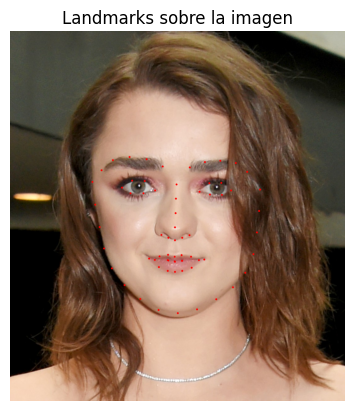

In [120]:
# Observar los landmarks generados en la imagen general
def cargar_landmarks(json_file):
    with open(json_file, 'r') as file:
        coords = json.load(file)
    return coords

def plotear_landmarks_sobre_imagen(image_path, landmarks):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f'No se pudo cargar la imagen en {image_path}')

    # Convertir de BGR a RGB para matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Dibujar los landmarks sobre la imagen
    for landmark in landmarks:
        cv2.circle(image_rgb, tuple(landmark), 3, (255, 0, 0), -1)


    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Landmarks sobre la imagen')
    plt.show()


json_file = '/content/FaceShape Dataset/landmarks/training_set/round (800).json'
image_path = '/content/FaceShape Dataset/training_set/Round/round (800).jpg'
landmarks = cargar_landmarks(json_file)

# Plotear las landmarks sobre la imagen
plotear_landmarks_sobre_imagen(image_path, landmarks)

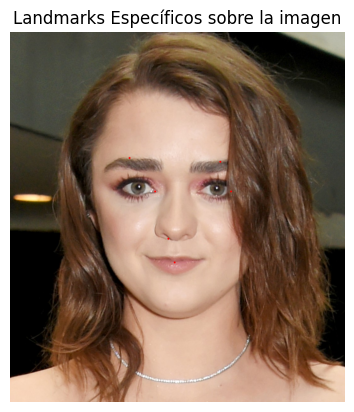

In [119]:
# Observar los landmarks que se especificaron
def cargar_landmarks_especificas(json_file):
    landmarks_especificas = []

    with open(json_file, 'r') as file:
        coords = json.load(file)
        if isinstance(coords, dict):
            specific_landmarks = coords['specific_landmarks']
            landmarks_especificas.append({
                'left_eye': specific_landmarks['left_eye'],
                'right_eye': specific_landmarks['right_eye'],
                'left_eyebrow': specific_landmarks['left_eyebrow'],
                'right_eyebrow': specific_landmarks['right_eyebrow'],
                'nose': specific_landmarks['nose'],
                'mouth': specific_landmarks['mouth']
            })
        else:
            raise ValueError(f"Formato de landmarks específicas desconocido en {json_file}")

    return landmarks_especificas

def plotear_landmarks_especificas_sobre_imagen(image_path, landmarks_especificas):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f'No se pudo cargar la imagen en {image_path}')

    # Convertir de BGR a RGB para matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Dibujar los landmarks específicos sobre la imagen
    for specific_landmarks in landmarks_especificas:
        for key, value in specific_landmarks.items():
            cv2.circle(image_rgb, tuple(value), 3, (255, 0, 0), -1)


    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title('Landmarks Específicos sobre la imagen')
    plt.show()


json_file = '/content/FaceShape Dataset/landmarks/training_set/specific/round (800)_specific.json'
image_path = '/content/FaceShape Dataset/training_set/Round/round (800).jpg'
landmarks_especificas = cargar_landmarks_especificas(json_file)

# Plotear las landmarks específicas sobre la imagen
plotear_landmarks_especificas_sobre_imagen(image_path, landmarks_especificas)

#Fully connected sencilla

#Landmarks generales

In [25]:
# Función para cargar los landmarks de los archivos .json
def cargar_landmarks(json_dir):
    landmarks = []
    labels = []
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            with open(os.path.join(json_dir, filename), 'r') as file:
                coords = json.load(file)
                landmarks.append(coords)
                label = filename.split(' ')[0]
                labels.append(label)
    return np.array(landmarks), np.array(labels)

# Cargar los landmarks y las etiquetas
train_landmarks, train_labels = cargar_landmarks(train_dir_landmarks)
test_landmarks, test_labels = cargar_landmarks(test_dir_landmarks)

# Normalizar los landmarks
def normalizar_landmarks(landmarks):
    normalized_landmarks = []
    for face in landmarks:
        face = np.array(face)
        # Normalización: escala los puntos para que estén entre 0 y 1
        face = face - np.min(face, axis=0)
        face = face / np.max(face)
        normalized_landmarks.append(face.flatten())
    return np.array(normalized_landmarks)

train_landmarks = normalizar_landmarks(train_landmarks)
test_landmarks = normalizar_landmarks(test_landmarks)

# Codificar las etiquetas en formato numérico
unique_labels = np.unique(train_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
train_labels = np.array([label_to_index[label] for label in train_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

# One-hot encode las etiquetas
train_labels = to_categorical(train_labels, num_classes=len(unique_labels))
test_labels = to_categorical(test_labels, num_classes=len(unique_labels))

In [67]:
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((68, 2, 1), input_shape=(136,)),  # 68 puntos con (x, y) coordenadas
    tf.keras.layers.Conv2D(32, (1, 1), activation='relu'),    # Convolución 1x1
    tf.keras.layers.MaxPooling2D(pool_size=(2, 1)),           # Reducción de dimensionalidad
    tf.keras.layers.Conv2D(64, (1, 1), activation='relu'),    # Otra convolución 1x1
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(unique_labels), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Se utiliza el learning rate scheduler para irlo variando
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 68, 2, 1)          0         
                                                                 
 conv2d_20 (Conv2D)          (None, 68, 2, 32)         64        
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 34, 2, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_21 (Conv2D)          (None, 34, 2, 64)         2112      
                                                                 
 flatten_10 (Flatten)        (None, 4352)              0         
                                                                 
 dense_32 (Dense)            (None, 128)               557184    
                                                     

In [68]:
# Entrenar el modelo
history = model.fit(train_landmarks, train_labels, epochs=200, batch_size=8, validation_split=0.2)

Epoch 1/200
398/398 [==============================] - 4s 6ms/step - loss: 1.6119 - accuracy: 0.2020 - val_loss: 1.6099 - val_accuracy: 0.1935
Epoch 2/200
398/398 [==============================] - 2s 6ms/step - loss: 1.6049 - accuracy: 0.2306 - val_loss: 1.5699 - val_accuracy: 0.3166
Epoch 3/200
398/398 [==============================] - 3s 9ms/step - loss: 1.4721 - accuracy: 0.3286 - val_loss: 1.3184 - val_accuracy: 0.3957
Epoch 4/200
398/398 [==============================] - 3s 7ms/step - loss: 1.3120 - accuracy: 0.3871 - val_loss: 1.2569 - val_accuracy: 0.4585
Epoch 5/200
398/398 [==============================] - 2s 6ms/step - loss: 1.2633 - accuracy: 0.4285 - val_loss: 1.2547 - val_accuracy: 0.4410
Epoch 6/200
398/398 [==============================] - 2s 6ms/step - loss: 1.2488 - accuracy: 0.4364 - val_loss: 1.2191 - val_accuracy: 0.4309
Epoch 7/200
398/398 [==============================] - 2s 6ms/step - loss: 1.2200 - accuracy: 0.4593 - val_loss: 1.2082 - val_accuracy: 0.4497

In [69]:
loss, accuracy = model.evaluate(test_landmarks, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

32/32 [==============================] - 0s 2ms/step - loss: 0.8809 - accuracy: 0.6727
Loss: 0.8809064626693726, Accuracy: 0.6727089881896973


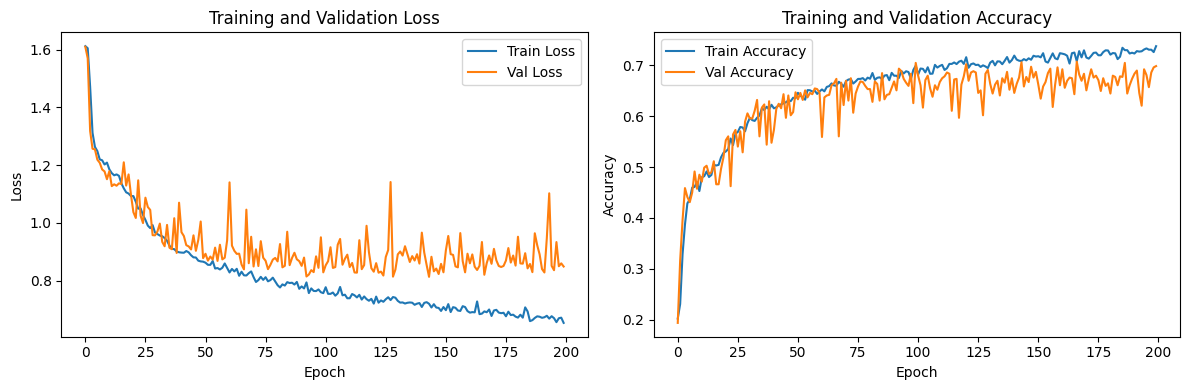

In [70]:
# Obtener métricas de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear gráficos
plt.figure(figsize=(12, 4))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 2ms/step


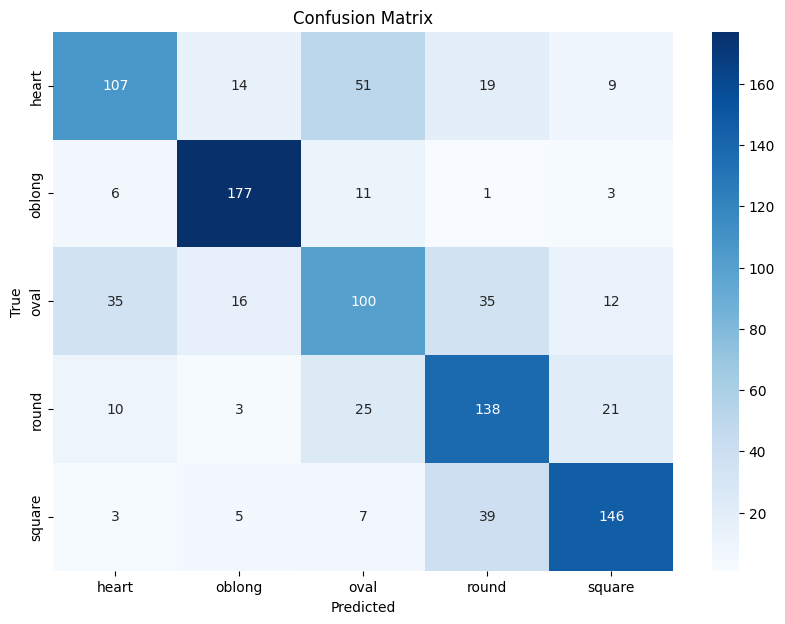

In [71]:
# Predicciones del modelo
predicciones = model.predict(test_landmarks)
predicted_classes = np.argmax(predicciones, axis=1)

# Convertir las etiquetas de prueba de one-hot encoded a etiquetas enteras
true_classes = np.argmax(test_labels, axis=1)

conf_matrix = confusion_matrix(true_classes, predicted_classes)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Landmarks especificos

In [76]:
#Landmarks especificos
# Directorios de los landmarks especificos
train_dir = '/content/FaceShape Dataset/landmarks/training_set/specific'
test_dir = '/content/FaceShape Dataset/landmarks/testing_set/specific'

# Función para cargar landmarks simplificados y sus etiquetas desde archivos JSON
def cargar_landmarks(json_dir):
    landmarks = []
    labels = []
    for filename in os.listdir(json_dir):
        if filename.endswith('.json'):
            with open(os.path.join(json_dir, filename), 'r') as file:
                coords = json.load(file)
                if isinstance(coords, dict):
                    left_eye = coords['left_eye']
                    right_eye = coords['right_eye']
                    left_eyebrow = coords['left_eyebrow']
                    right_eyebrow = coords['right_eyebrow']
                    nose = coords['nose']
                    mouth = coords['mouth']

                    landmarks_array = [
                        left_eye[0], left_eye[1],
                        right_eye[0], right_eye[1],
                        left_eyebrow[0], left_eyebrow[1],
                        right_eyebrow[0], right_eyebrow[1],
                        nose[0], nose[1],
                        mouth[0], mouth[1]
                    ]
                    landmarks.append(landmarks_array)
                else:
                    landmarks.append(coords)

                label = filename.split(' ')[0]
                labels.append(label)
    return np.array(landmarks), np.array(labels)

# Cargar los landmarks y las etiquetas
train_landmarks, train_labels = cargar_landmarks(train_dir_landmarks)
test_landmarks, test_labels = cargar_landmarks(test_dir_landmarks)

# Normalizamos los landmarks con la misma funcion de antes
train_landmarks = normalizar_landmarks(train_landmarks)
test_landmarks = normalizar_landmarks(test_landmarks)

# Codificar las etiquetas en formato numérico
unique_labels = np.unique(train_labels)
label_to_index = {label: index for index, label in enumerate(unique_labels)}
train_labels = np.array([label_to_index[label] for label in train_labels])
test_labels = np.array([label_to_index[label] for label in test_labels])

# One-hot encode las etiquetas
train_labels = to_categorical(train_labels, num_classes=len(unique_labels))
test_labels = to_categorical(test_labels, num_classes=len(unique_labels))

In [87]:
#El modelo vario ligeramente por el input_shape
model = tf.keras.Sequential([
    tf.keras.layers.Reshape((136, 1), input_shape=(136,)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(len(unique_labels), activation='softmax')
])

# Compilar el modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo para verificar la arquitectura
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 136, 1)            0         
                                                                 
 flatten_16 (Flatten)        (None, 136)               0         
                                                                 
 dense_60 (Dense)            (None, 128)               17536     
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 64)                4160      
                                                                 
 dense_63 (Dense)            (None, 5)                 325       
                                                                 
Total params: 30277 (118.27 KB)
Trainable params: 302

In [88]:
# Entrenar el modelo
history = model.fit(train_landmarks, train_labels, epochs=200, batch_size=8, validation_split=0.2)

Epoch 1/200
398/398 [==============================] - 2s 3ms/step - loss: 1.6179 - accuracy: 0.1967 - val_loss: 1.6074 - val_accuracy: 0.2161
Epoch 2/200
398/398 [==============================] - 1s 3ms/step - loss: 1.5964 - accuracy: 0.2394 - val_loss: 1.5710 - val_accuracy: 0.2889
Epoch 3/200
398/398 [==============================] - 1s 2ms/step - loss: 1.5529 - accuracy: 0.2821 - val_loss: 1.5361 - val_accuracy: 0.3065
Epoch 4/200
398/398 [==============================] - 1s 3ms/step - loss: 1.5119 - accuracy: 0.3129 - val_loss: 1.4658 - val_accuracy: 0.3769
Epoch 5/200
398/398 [==============================] - 1s 3ms/step - loss: 1.4497 - accuracy: 0.3352 - val_loss: 1.4905 - val_accuracy: 0.2864
Epoch 6/200
398/398 [==============================] - 1s 3ms/step - loss: 1.3393 - accuracy: 0.4103 - val_loss: 1.2625 - val_accuracy: 0.4309
Epoch 7/200
398/398 [==============================] - 1s 3ms/step - loss: 1.2971 - accuracy: 0.4285 - val_loss: 1.4555 - val_accuracy: 0.3266

In [121]:
loss, accuracy = model.evaluate(test_landmarks, test_labels)
print(f"Loss: {loss}, Accuracy: {accuracy}")

32/32 [==============================] - 0s 2ms/step - loss: 1.0068 - accuracy: 0.5982
Loss: 1.0068087577819824, Accuracy: 0.5981873273849487


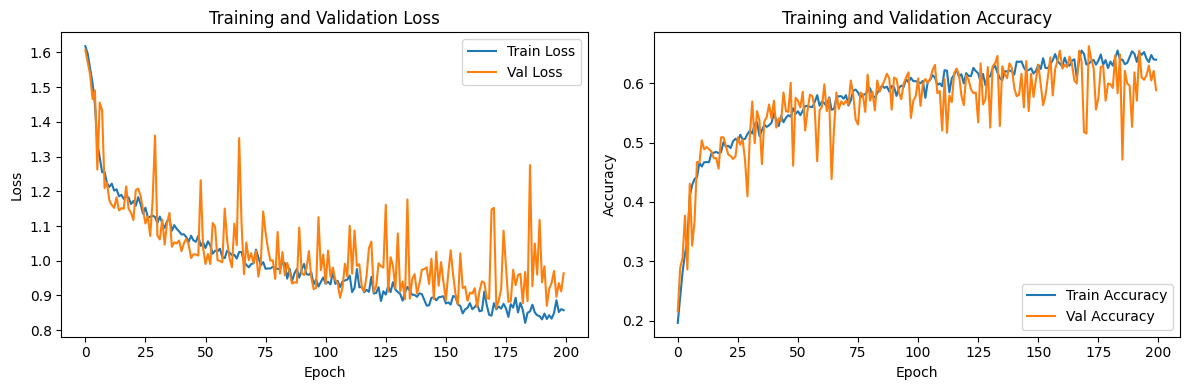

In [89]:
# Obtener métricas de entrenamiento y validación
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Crear gráficos
plt.figure(figsize=(12, 4))

# Gráfico de Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

32/32 [==============================] - 0s 2ms/step


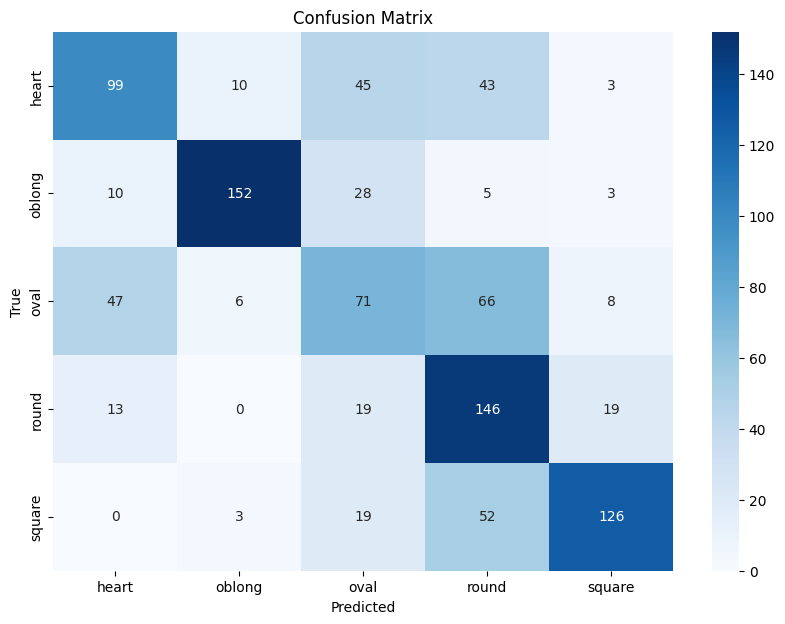

In [90]:
# Predicciones del modelo
predicciones = model.predict(test_landmarks)
predicted_classes = np.argmax(predicciones, axis=1)

# Convertir las etiquetas de prueba de one-hot encoded a etiquetas enteras
true_classes = np.argmax(test_labels, axis=1)


conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#Los mejores peinados segun tipo de rostro:

*   Oval -> Favorecen cortes con capas largas, ondas a la altura de los hombros, flequillo completo, un bob en capas o un pixie barrido hacia un lado.
*   Square -> Se recomiendan las melenas onduladas con flequillo despeinado, flequillo suave barrido hacia un lado, o capas largas con flequillo funcionan mejor.
*   Heart -> Los rostros en forma de corazón lucen mejor con flequillos rectos y capas onduladas o un bob a la altura del mentón con flequillo.
*   Oblong -> Deben suavizar los bordes y mandíbulas marcadas con capas, volumen y flequillo barrido hacia un lado o desfilado. Las capas largas y ángulos añaden movimiento y textura al cabello.
*   Round ->  Se ven bien con un bob largo, que lleva la atención hacia abajo para alargar visualmente el rostro, se benefician de cortes que alargan, como el cabello largo y liso, ondas voluminosas largas, bobs despeinados y flequillos barridos con los lados recortados.

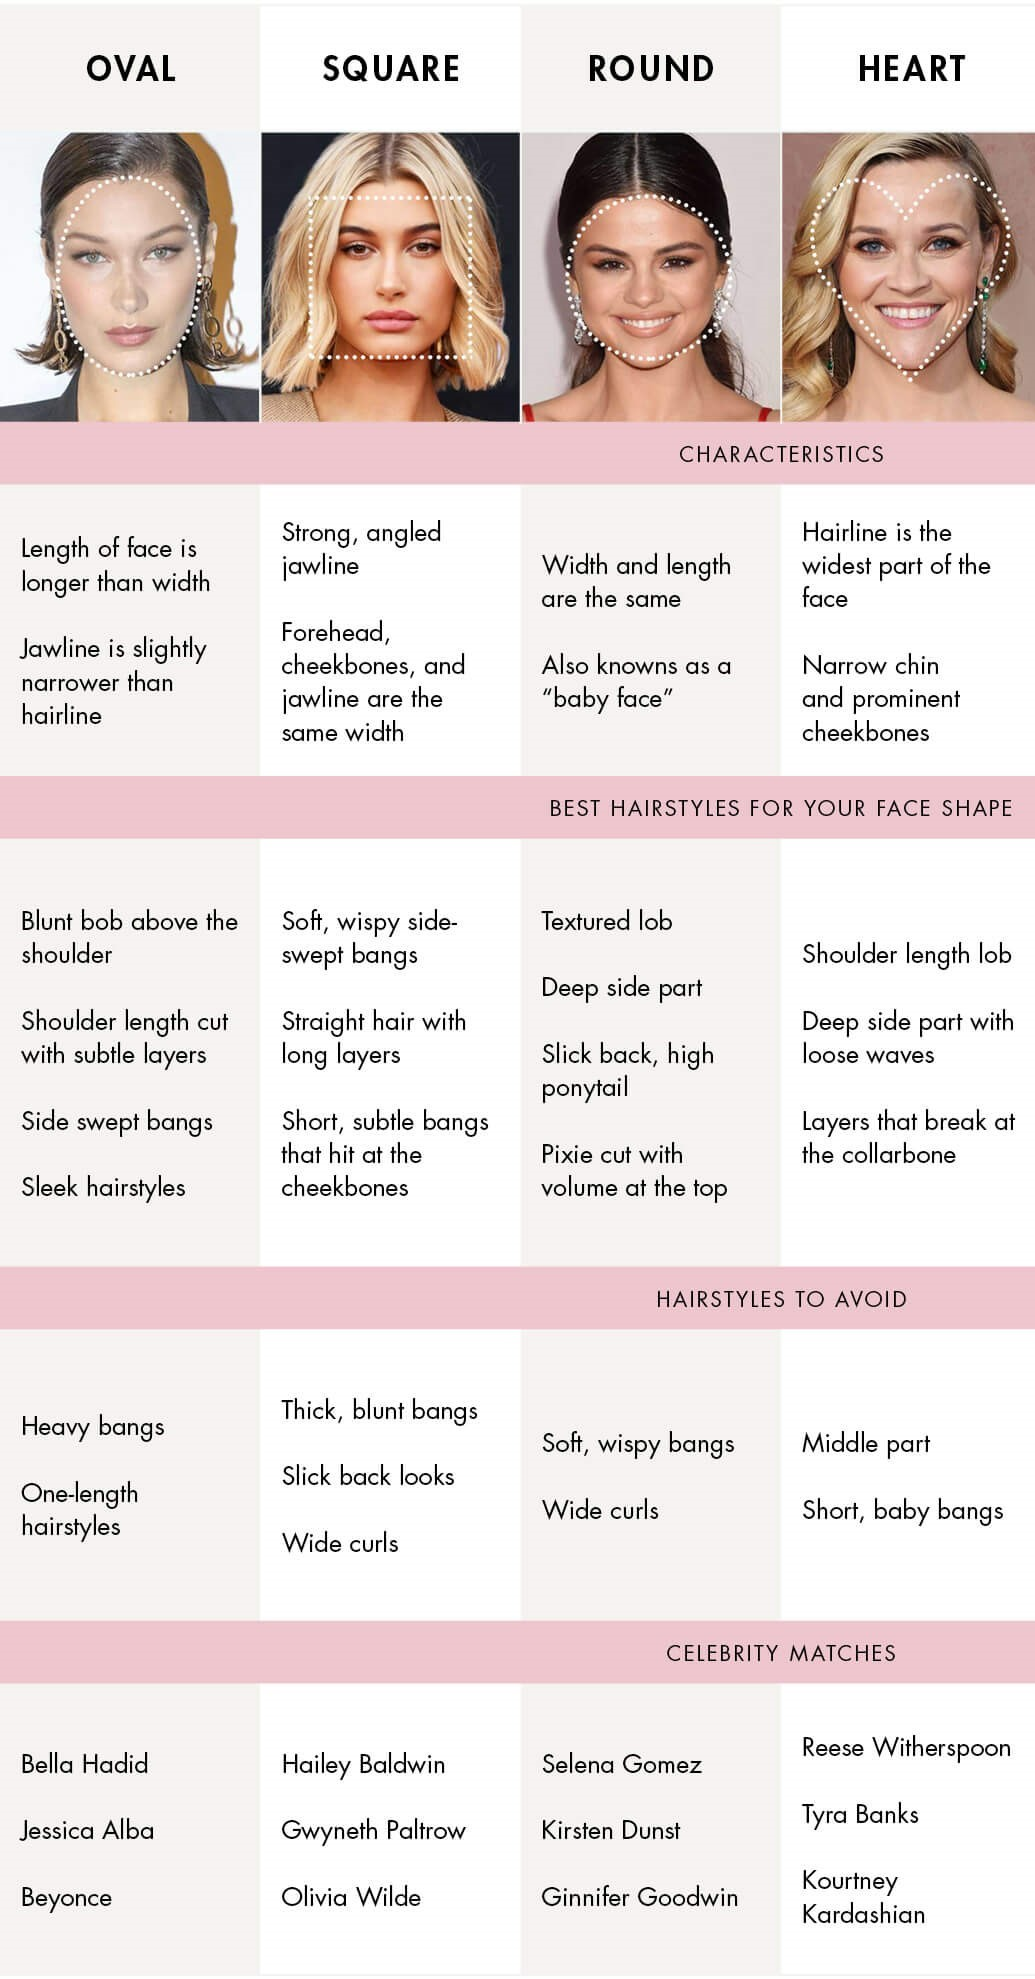